In [86]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
import altair as alt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from pyarrow import feather
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

In [7]:
# load in feather datasets 
# training dataset
avocado = pd.read_feather("../data/train.feather")
avocado.head()
# test dataset
# avocado_test = pd.read_feather("test.feather")
# avocado_test.head()

,X1,date,average_price,total_volume,PLU_4046,PLU_4225,PLU_4770,total_bags,small_bags,large_bags,xlarge_bags,type,year,region,month,year_month
0,0.0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015.0,Albany,Dec,2015-12
1,1.0,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015.0,Albany,Dec,2015-12
2,2.0,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015.0,Albany,Dec,2015-12
3,3.0,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015.0,Albany,Dec,2015-12
4,4.0,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015.0,Albany,Nov,2015-11


In [8]:
# Which features do we want to keep?
avocado.columns
# want month, region, type as our features

Index(['X1', 'date', 'average_price', 'total_volume', 'PLU_4046', 'PLU_4225',
       'PLU_4770', 'total_bags', 'small_bags', 'large_bags', 'xlarge_bags',
       'type', 'year', 'region', 'month', 'year_month'],
      dtype='object')

In [70]:
# Split the data into target and features
avocado_x = avocado[['region', 'type', 'month']]
avocado_y = avocado['average_price']

# avocado_test_x = avocado_test[['region', 'type', 'month']]
# avocado_test_y = avocado['AveragePrice']

# need to convert categorical to numerical using one-hot-encoding
categorical_features = ['region', 'type', 'month']

preprocessor = ColumnTransformer(transformers=[
    ('ohe', OneHotEncoder(), categorical_features)
])

# applying one hot encoding to the training features
avocado_x = preprocessor.fit_transform(avocado_x)

# apply the same transformation to the test features (but don't fit!)

# avocado_test_x = pd.DataFrame(preprocessor.transform(avocado_test_x),
#                              index=avocado_test_x.index,
#                              columns=avocado_x.columns)

In [71]:
# fit rfr model
rfr = RandomForestRegressor(random_state=123)
rfr.fit(avocado_x, avocado_y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=123, verbose=0, warm_start=False)

In [72]:
fold_accuracies = cross_val_score(estimator=rfr, X=avocado_x, y=avocado_y, cv=5)
print(fold_accuracies)
print(np.mean(fold_accuracies))
print(np.std(fold_accuracies))
# the standard deviation is much greater than the mean accuracy, 
# this is probably not a good model...

[-0.95061134  0.15556973  0.52072718 -0.1881055   0.17626009]
-0.057231968601601915
0.4998188593800734


In [82]:
# find optimal hyperparameters

rfr_parameters = {'max_depth': range(1, 20),
                  'n_estimators': range(1, 100)}

random_rfr = RandomizedSearchCV(rfr, rfr_parameters, n_iter=10,
             cv=5)

random_rfr.fit(avocado_x, avocado_y).best_params_

{'n_estimators': 46, 'max_depth': 13}

In [83]:
fold_accuracies = cross_val_score(estimator=random_rfr, X=avocado_x, y=avocado_y, cv=5)
cv_scores_dict = {'Fold': [1, 2, 3, 4, 5],
                  'Negative_Mean_Squared_Error': fold_accuracies}
#for i in range(5):
#    cv_scores_dict('Fold')[i] = 

#print(fold_accuracies)
#print(np.mean(fold_accuracies))
#print(np.std(fold_accuracies))
# The standard error is much more reasonable here

In [47]:
pd.DataFrame(cv_scores_dict)

,Fold,Negative_Mean_Squared_Error
0,1,-0.063880
1,2,-0.071218
2,3,-0.054612
3,4,-0.133494
4,5,-0.140485


In [73]:
features = pd.get_dummies(avocado[['region', 'type', 'month']])
feature_list = list(features.columns)

In [91]:
feature_df = pd.DataFrame({"feature_names": feature_list,
             "importance": random_rfr.best_estimator_.feature_importances_})

In [100]:
feature_df.sort_values(["importance"], ascending=False, inplace=True)

In [105]:
feature_df.reset_index(drop=True, inplace=True)

In [119]:
feature_df[:10]

,feature_names,importance
0,type_organic,0.448443
1,type_conventional,0.195948
2,region_HartfordSpringfield,0.038948
3,region_SanFrancisco,0.036253
4,month_Nov,0.032453
5,month_Dec,0.025815
6,region_NewYork,0.022404
7,region_Houston,0.021718
8,region_PhoenixTucson,0.019549
9,month_Feb,0.016290


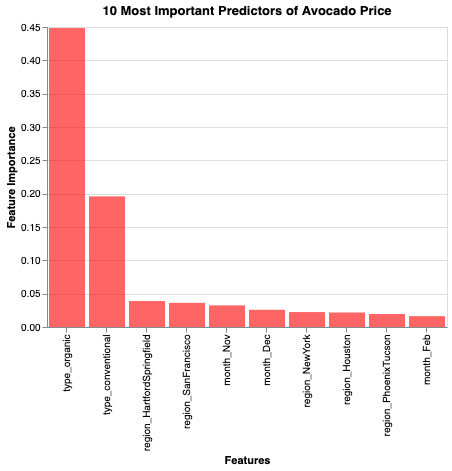

In [127]:
alt.Chart(feature_df[:10]).mark_bar(color="red", opacity=0.6).encode(
    x= alt.X("feature_names:N",
             sort=alt.SortField(field='importance:Q'),
             title="Features"),
    y = alt.Y("importance:Q", title="Feature Importance")
).properties(title="10 Most Important Predictors of Avocado Price",
             width=400)

In [39]:
rfr.score(avocado_x, avocado_y)

0.7098694373793282

In [25]:
lr = LinearRegression()
lr.fit(avocado_x, avocado_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [26]:
lr.score(avocado_x, avocado_y)

0.6093976419611092

In [27]:
list(zip(feature_list, lr.coef_))

[('region_Albany', -0.21956689704181856),
 ('region_Atlanta', -0.02063048139350373),
 ('region_BaltimoreWashington', -0.2252418053543965),
 ('region_Boise', -0.03542732401517944),
 ('region_Boston', -0.04607431124402879),
 ('region_BuffaloRochester', -0.16470506225733672),
 ('region_California', 0.06159784503280273),
 ('region_Charlotte', 5.4598699459447435e-05),
 ('region_Chicago', -0.35467143646478966),
 ('region_CincinnatiDayton', -0.3076291833538522),
 ('region_Columbus', -0.47154125332270175),
 ('region_DallasFtWorth', -0.33197930758110905),
 ('region_Denver', -0.27899749448048494),
 ('region_Detroit', -0.059215353412605545),
 ('region_GrandRapids', -0.21923596071127344),
 ('region_GreatLakes', -0.05203421669515846),
 ('region_HarrisburgScranton', 0.2673703795934898),
 ('region_HartfordSpringfield', -0.5060012988056523),
 ('region_Houston', -0.2397526611836631),
 ('region_Indianapolis', -0.04520831253474802),
 ('region_Jacksonville', -0.1752177232435257),
 ('region_LasVegas', -0.3